In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\Cartera Nivelacion formateada.xlsx', sheet_name = 'Hoja2')

In [3]:
df

,ESTACION,PV,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,DATO V+,V-,Cota
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Esta funcion pide un valor al usuario para modificar la distancia
def solicitar_nueva_distancia(columna):
    while True:
        try:
            nuevo_valor = float(input(f"Ingrese un nuevo valor para la {columna}: "))
            return nuevo_valor
        except ValueError:
            print("Entrada inválida. Debe ingresar un número.")

In [5]:
for i in range(len(df)):
    diferencia = abs(df.loc[i, 'Distancia1'] - df.loc[i, 'Distancia2'])
    if not (0.5 <= diferencia <= 7):
        print(f"\nFila {i}: La diferencia entre Distancia1 ({df.loc[i, 'Distancia1']}) y Distancia2 ({df.loc[i, 'Distancia2']}) es {diferencia}, fuera del rango permitido.")
        # Pedimos al usuario que elija qué distancia cambiar
        cambiar = input("¿Qué distancia desea cambiar? Ingrese 1 para Distancia1 o 2 para Distancia2: ")
        if cambiar == "1":
            df.loc[i, 'Distancia1'] = solicitar_nueva_distancia('Distancia1')
        elif cambiar == "2":
            df.loc[i, 'Distancia2'] = solicitar_nueva_distancia('Distancia2')
        else:
            print("Opción inválida, no se realizó ningún cambio.")


Fila 0: La diferencia entre Distancia1 (nan) y Distancia2 (nan) es nan, fuera del rango permitido.


Opción inválida, no se realizó ningún cambio.


In [6]:
df

,ESTACION,PV,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,DATO V+,V-,Cota
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['Distancia entre cambios'] = df['Distancia1'] + df['Distancia2']

In [8]:
for i in range(1, len(df)):
    df.loc[i, 'Distancia Absoluta'] = df.loc[i - 1, 'Distancia Absoluta'] + df.loc[i - 1, 'Distancia entre cambios']

In [ ]:
# Utilizamos esta formula para realizar la operacion columna por columna
df['resta'] = df['DATO V+'] - df['V-']

df['Sube'] = np.where(df['resta'] > 0, df['resta'], np.nan)
df['Baja'] = np.where(df['resta'] < 0, abs(df['resta']), np.nan)

In [10]:
# Crear columnas desplazadas para "Sube" y "Baja", corriendo una fila hacia abajo
df['Sube_shifted'] = df['Sube'].shift(1)
df['Baja_shifted'] = df['Baja'].shift(1)

# Mantenemos intacto el primer valor de cota para no desorganizar los datos dados
# Este es un bucle que inicia desde la fila 1 (No inicia desde la fila 0 puesto que corrimos una fila hacia abajo para no modificar el valor de cota)
for i in range(1, len(df)):
    # Esta linea lo que hace es verificar si el valor NO es un Nan, en caso de que no lo sea especificamente en la posicion
    # i de la columna sube_shifted lo que hacemos es que en la posicion i de cota se sume el valor de la fila de arriba de cota con 
    # Sube shifted dependiendo si es o no un sube o un baja
    if not pd.isna(df.loc[i, 'Sube_shifted']):
        df.loc[i, 'Cota'] = df.loc[i-1, 'Cota'] + df.loc[i, 'Sube_shifted']
    elif not pd.isna(df.loc[i, 'Baja_shifted']):
        df.loc[i, 'Cota'] = df.loc[i-1, 'Cota'] - df.loc[i, 'Baja_shifted']

In [11]:
# Eliminar las columnas auxiliares para que no sean visibles
df = df.drop(columns=['Sube_shifted', 'Baja_shifted', 'resta'])

In [12]:
df

,ESTACION,PV,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,DATO V+,V-,Cota,Sube,Baja
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Ahora calculamos la altura instrumental a partir de la primera hoja para comparar los resultados
df2 = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\Cartera Nivelacion formateada.xlsx')

In [14]:
df2

,ESTACION,PV,DATO V+,V-,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,ALTURA INSTRUMENTAL,COTA
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Bucle while para calcular ALTURA INSTRUMENTAL y COTA hasta que no haya cambios
cambios_realizados = True

while cambios_realizados:
    cambios_realizados = False  # Asumir que no se harán más cambios en esta iteración
    for i in range(len(df2)):
        if i == 0:
            # Para la primera fila, calcular ALTURA INSTRUMENTAL con COTA y DATO V+
            df2.loc[i, 'ALTURA INSTRUMENTAL'] = df2.loc[i, 'COTA'] + df2.loc[i, 'DATO V+']
            continue

        # Obtener COTA anterior
        cota_anterior = df2.loc[i - 1, 'COTA']

        # Calcular ALTURA INSTRUMENTAL usando la COTA actual
        altura_instrumental_anterior = df2.loc[i - 1, 'ALTURA INSTRUMENTAL']
        df2.loc[i, 'ALTURA INSTRUMENTAL'] = df2.loc[i, 'DATO V+'] + df2.loc[i, 'COTA']

        # Calcular COTA
        v_minus = df2.loc[i - 1, 'V-'] if pd.notna(df2.loc[i - 1, 'V-']) else 0  # Manejar valores nulos
        nueva_cota = altura_instrumental_anterior - v_minus

        # Verificar si hay cambios en COTA
        if df2.loc[i, 'COTA'] != nueva_cota:
            df2.loc[i, 'COTA'] = nueva_cota
            cambios_realizados = True  # Se ha realizado un cambio

In [16]:
df2

,ESTACION,PV,DATO V+,V-,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,ALTURA INSTRUMENTAL,COTA
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como podemos evidenciar ambas cotas dan el mismo resultado por ende el codigo funciona correctamente

In [17]:
df2['Distancia entre cambios'] = df2['Distancia1'] + df2['Distancia2']

In [18]:
for i in range(1, len(df2)):
    df2.loc[i, 'Distancia Absoluta'] = df2.loc[i - 1, 'Distancia Absoluta'] + df2.loc[i - 1, 'Distancia entre cambios']

In [19]:
df2

,ESTACION,PV,DATO V+,V-,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,ALTURA INSTRUMENTAL,COTA
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Mostrar Las vistas intermedias, osea los valores de bajas
vistas_intermedias = df[['PV', 'Baja']].dropna().reset_index(drop=True)
print(vistas_intermedias)

Empty DataFrame
Columns: [PV, Baja]
Index: []


In [21]:
df['Altura instrumental'] = df2['ALTURA INSTRUMENTAL']

In [22]:
# Eliminar la columna 'Altura instrumental' y guardarla
altura_instrumental = df.pop('Altura instrumental')

# Insertar la columna en la posición 6
df.insert(8, 'Altura instrumental', altura_instrumental)

In [23]:
df

,ESTACION,PV,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,DATO V+,V-,Altura instrumental,Cota,Sube,Baja
0,NaN,Valores iniciales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


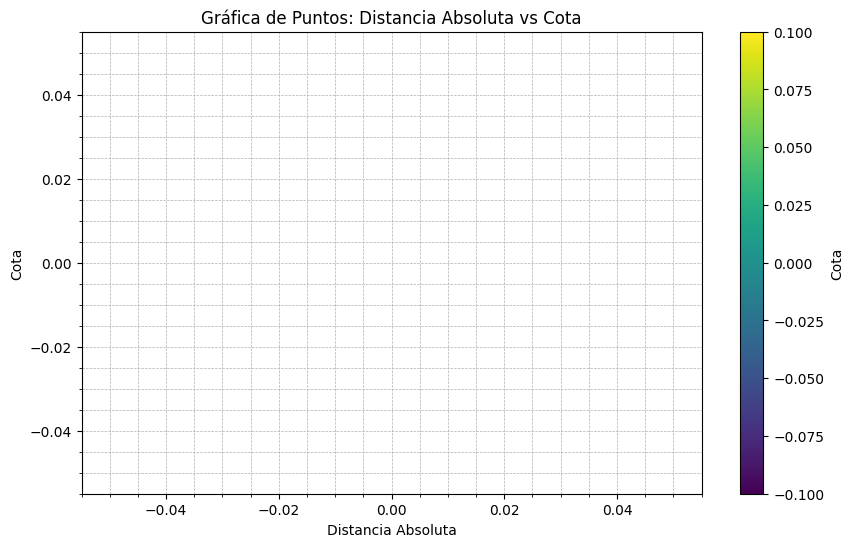

In [24]:
# Crear la figura
plt.figure(figsize=(10, 6))

# Graficar los puntos usando color en función de la columna Cota
scatter = plt.scatter(df['Distancia Absoluta'].round(2), df['Cota'], 
                      c=df['Cota'], cmap='viridis', s=100, marker='o')

# Mostrar las coordenadas (x, y) en cada punto con dos decimales
for i in range(len(df)):
    plt.text(df['Distancia Absoluta'].round(2)[i], df['Cota'][i], 
             f'({df["Distancia Absoluta"].round(2)[i]}, {df["Cota"][i]:.2f})', 
             fontsize=9, ha='right', va='bottom')

# Agregar barra de colores para visualizar los valores de Cota
plt.colorbar(scatter, label='Cota')

# Agregar títulos y etiquetas
plt.title('Gráfica de Puntos: Distancia Absoluta vs Cota')
plt.xlabel('Distancia Absoluta')
plt.ylabel('Cota')

# Ajustar la cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Ajustar estilo y grosor
plt.minorticks_on()  # Activar las marcas menores de los ejes

# Ampliar los límites de los ejes en 10 unidades
plt.xlim(df['Distancia Absoluta'].min() - 16, df['Distancia Absoluta'].max() + 10)
plt.ylim(df['Cota'].min() - 2, df['Cota'].max() + 2)

# Mostrar la gráfica
plt.show()
